# Imports and Global Variables

In [83]:
from typing import List
from config.endpoints import MAINNET_BASE_URL
from helpers.utility import _make_get_request, _make_post_request
from helius import NFTAPI, NameAPI, BalancesAPI, WebhooksAPI, TransactionsAPI
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import os
import time
import json
from collections import defaultdict


In [2]:
# Persistent Variables

LAMPORT_SCALE = 1e9

In [37]:
load_dotenv()

True

In [4]:
# class TransactionsAPI:
#     def __init__(self, api_key: str):
#         self.base_url = MAINNET_BASE_URL
#         self.headers = {"Authorization": f"Bearer {api_key}"}
#         self.api_key_query = f"?api-key={api_key}"

#     def get_raw_transactions(
#         self, 
#         accounts: List[str], 
#         start_slot: int=None,
#         end_slot: int=None,
#         start_time: int=None,
#         end_time: int=None,
#         limit: int=None,
#         sort_order: str=None,
#         pagination_token: str=None
#         ):

#         path = "/v1/raw-transactions"
#         url = self.base_url + path + self.api_key_query
#         payload = {
#             "query": {
#                 "accounts": accounts,
#                 "startSlot": start_slot,
#                 "endSlot": end_slot,
#                 "startTime": start_time,
#                 "endTime": end_time
#             },
#             "options": {
#                 "limit": limit,
#                 "sortOrder": sort_order,
#                 "paginationToken": pagination_token
#             }
#         }
#         return _make_post_request(url, payload)

#     def get_parsed_transactions(self, transactions: List[str], commitment: str=None):
#         path = "/v0/transactions"
#         if commitment:
#             url = self.base_url + path + self.api_key_query + "?commitment=commitment"
#         else:
#             url = self.base_url + path + self.api_key_query
#         payload = {
#             "transactions": transactions
#         }
#         return _make_post_request(url, payload)

#     def get_parsed_transaction_history(
#         self, 
#         address: str, 
#         before: str='', 
#         until: str='', 
#         commitment: str='',
#         source: str='',
#         type: str=''
#         ):
        
#         path = f"/v0/addresses/{address}/transactions"
#         params = {
#             "before": before,
#             "until": until,
#             "commitment": commitment,
#             "source": source,
#             "type": type
#         }

#         url = self.base_url + path + self.api_key_query
#         print(f'url: {url}')
#         return _make_get_request(url, params=params)

In [38]:
HELIUS_API_KEY = os.getenv('HELIUS_API_KEY')
VYBE_API_KEY = os.getenv('VYBE_API_KEY')
NANSEN_API_KEY = os.getenv('NANSEN_API_KEY')


In [6]:
test_address = 'AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU'

# Flipside Data (Balances over time)

Here is the Flipside Query; when moving to live app will use the Flipside API to retrieve this dynamically: https://flipsidecrypto.xyz/studio/queries/f72285d7-f3d4-4596-a9cd-8785187005a2

In [7]:
os.getcwd()

'c:\\Users\\Brandyn\\projects\\solana_analysis_tool\\notebooks'

In [8]:
os.chdir('..')

In [9]:
balance_df = pd.read_csv('data/solana_balance_history_test.csv').dropna(how='all')

# Strip BOMs or invisible characters from column names
balance_df.columns = balance_df.columns.str.replace('\ufeff', '', regex=False).str.strip()

# Optionally: remove rows where any column has just a BOM or is empty/whitespace
balance_df = balance_df[~balance_df.apply(lambda row: row.astype(str).str.contains('\ufeff|^\s*$', regex=True)).any(axis=1)]

sol_mask = (
    (balance_df['MINT'] == 'So11111111111111111111111111111111111111111') &
    (balance_df['SYMBOL'].isna())
)

balance_df.loc[sol_mask, 'SYMBOL'] = 'SOL'
balance_df.loc[sol_mask, 'NAME'] = 'Solana'

balance_df['TX_ID'] = balance_df['TX_ID'].str.lower()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Brandyn\AppData\Local\Temp\ipykernel_15100\3085726178.py:7: SyntaxWarning: invalid escape sequence '\s'
  balance_df = balance_df[~balance_df.apply(lambda row: row.astype(str).str.contains('\ufeff|^\s*$', regex=True)).any(axis=1)]


In [10]:
# Any nan values left should be LP tokens

balance_df[balance_df['SYMBOL'].isna()]

,BLOCK_TIMESTAMP,OWNER,MINT,PRE_BALANCE,BALANCE,TX_ID,SYMBOL,NAME
481,2024-01-27 20:02:00.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,21.284506,0.000000,ag9wy4nng7vgmgvwmbmikudfcgk9sigh9xhbgumq9lcfl8...,NaN,NaN
486,2024-01-27 20:00:42.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,0.000000,21.284506,3ktq7dyxvuoknsnhkhd4wmgcvxgq5cdxm6zpuunfjc1tgb...,NaN,NaN
494,2024-01-27 19:56:38.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,38.261386,0.000000,5xblmj697ixeazt6azmd3fxx26ckyuwhma2pmqmpyacdry...,NaN,NaN
496,2024-01-27 19:54:37.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,0.000000,38.261386,2jgmfwybccr51sgxupejvvprrhas1xyxpgtz96drrxnnmb...,NaN,NaN
506,2024-01-27 19:52:56.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,12.880316,0.000000,wmkk8qpz8xnk1kw1zaggersbbbegdm6prxwyidvbdcu4wv...,NaN,NaN
509,2024-01-27 19:51:51.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,10.000000,12.880316,t1egxx8diqh5ak4ptkny6ajru96dwe2r8yyjraqssj4cxy...,NaN,NaN
511,2024-01-27 19:47:10.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,0.000000,10.000000,deymhggrurmjvatdnhmqauszfxhzrxftxps3e5bgtes7vj...,NaN,NaN
525,2024-01-12 00:29:26.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,B9uEZfxJoAsc51BZs6rNs8XtYVu5vfVrhbCuDCJ7mPEE,0.000000,5.000000,qwsnf1ioo2ucggywbzdfa1knav8vujgg7dkwgkazfyp6q6...,NaN,NaN
526,2024-01-11 23:02:04.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,5.711749,0.000000,wnz5j6dcgtjmigf8dxvbh72t4ks6bo3kvtsgmbzl7trjdn...,NaN,NaN
528,2024-01-11 22:57:58.000,AGPZnBZUxmhAtcp8XjT4n8bCia9dEYhhm16M2sfFvmTU,9HB4kAMLSYfGFfN142DKMyPyHyZQ8pXF8M1STbDudodY,0.000000,5.711749,5238f2m2jwjbsqsnb5k1l8b6mj5z9d1xs9eeakwzjkpzsf...,NaN,NaN


In [11]:
os.chdir('notebooks')

In [12]:
os.getcwd()

'c:\\Users\\Brandyn\\projects\\solana_analysis_tool\\notebooks'

# Helius API Calls

In [88]:
def get_all_signatures(account_address, helius_api_key, max_pages=20, limit=100):
    url = f"https://mainnet.helius-rpc.com/?api-key={helius_api_key}"
    collected = []
    before = None

    for _ in range(max_pages):
        payload = {
            "jsonrpc": "2.0",
            "id": "1",
            "method": "getSignaturesForAddress",
            "params": [account_address, {"limit": limit, **({"before": before} if before else {})}]
        }

        response = requests.post(
            url,
            headers={"Content-Type": "application/json"},
            data=json.dumps(payload)
        )

        try:
            data = response.json()
            if "error" in data:
                print(f"❌ Error: {data['error']['message']}")
                break

            batch = data["result"]
            if not batch:
                break

            collected.extend(batch)
            before = batch[-1]["signature"]  # Move to next batch

            time.sleep(0.5)  # Avoid rate-limits

        except Exception as e:
            print(f"Exception: {e}")
            break

    return collected

In [ ]:
signatures = get_all_signatures(test_address, HELIUS_API_KEY)

signatures_dict = {}

for sig in signatures:
    time = sig.get('blockTime')
    signature_str = sig.get('signature')

    signatures_dict[signature_str] = time

signatures_dict

{'6mPqrKS4AKYJeZ3JLjjubHSwNB96oiJdFX1DgeZNZEBHxMTEx9RUZYt2SyFRvpPohpXm9RRABbVb2CEHgpdTzGv': 1743941539,
 '29aP1yrCx2dbJM4Mxk8257G5e87bY7CgxySDS6LiAAmsxXLspNqdbGpYZFYiwJqjPLwBU5V6gwZ2gvuf4FSc5YrU': 1743898250,
 '2D7D4ndxhZfwZ6TRN6pzY7PQEFkRKTQhQjQ1zpz5MyNDVSP4BGV7NiSja2EvF1bKMa6NfudBP2DQjoocAibqqGQs': 1743898245,
 'nPrzWnG7SLNepcPeBWjEMKadD6WNuWScRgEwEqSNsHiZNN5kJqsniF9ArMZRStMH5T4GnNcUU97YXecsyXocsJ9': 1743896323,
 'yqSAMWuNg3pC9H5EZJmTr1MudCuUajZye13BMfaS2atLvCUPiKx3FzcxhXZEpE48dKZ7Qt2PqKmh7JRUhY4FxTZ': 1743896305,
 '4Mq9XxeG49KHnJwWipQWV6EkjQJDrF6VFQaqr1v7xiUWEpar5UZFx2CLzWaKyosrUGKJz1ZUEHo3T7g13R8azb4z': 1743896305,
 '65mbqVyFo9kGav1zdCTUjdYtVZkRb82m2E9ZqedDwWdKDiPKuxNKmMsVHFWnBxMin2SncasNB8FGmMM7ANRFRtLn': 1743896210,
 '4oJDpv6EPm9zyh5ifuGUSkT6qe3mNDKHLWU7sbNBwPRY8CNTwU3SdoczL65axR1RfR1gAAuC9uUWY11BFTuWTWPW': 1743896146,
 '4T6L9vPZ7HysWjZk9mmJxWEueV4FXMdZbGrkFQ1gdvMbYk6vwAQJXub8gMGiqSP6xUrGBRco8hZKY9YA2QBvJbHo': 1743896107,
 '2u8fAc6rYB1SsHrVtZBnqezCvWYjTuHuda5rR2HDfLdYF65Git24RGY2

In [103]:
signatures_array = list(signatures_dict.keys())

In [110]:
def v0_transactions_all(signatures, helius_api_key):
    import time
    url = f"https://api.helius.xyz/v0/transactions?api-key={helius_api_key}"
    headers = {"Content-Type": "application/json"}

    all_results = []
    batch_size = 100

    for i in range(0, len(signatures), batch_size):
        batch = signatures[i:i+batch_size]
        payload = json.dumps({"transactions": batch})

        response = requests.post(url, headers=headers, data=payload)

        try:
            data = response.json()
            if isinstance(data, dict) and "error" in data:
                print(f"❌ Error at batch {i // batch_size}: {data['error']}")
                continue

            all_results.extend(data)

        except Exception as e:
            print(f"❌ Exception during batch {i // batch_size}: {e}")

        time.sleep(0.3)  # Optional rate limit buffer

    return all_results


In [111]:
signatures_array

['6mPqrKS4AKYJeZ3JLjjubHSwNB96oiJdFX1DgeZNZEBHxMTEx9RUZYt2SyFRvpPohpXm9RRABbVb2CEHgpdTzGv',
 '29aP1yrCx2dbJM4Mxk8257G5e87bY7CgxySDS6LiAAmsxXLspNqdbGpYZFYiwJqjPLwBU5V6gwZ2gvuf4FSc5YrU',
 '2D7D4ndxhZfwZ6TRN6pzY7PQEFkRKTQhQjQ1zpz5MyNDVSP4BGV7NiSja2EvF1bKMa6NfudBP2DQjoocAibqqGQs',
 'nPrzWnG7SLNepcPeBWjEMKadD6WNuWScRgEwEqSNsHiZNN5kJqsniF9ArMZRStMH5T4GnNcUU97YXecsyXocsJ9',
 'yqSAMWuNg3pC9H5EZJmTr1MudCuUajZye13BMfaS2atLvCUPiKx3FzcxhXZEpE48dKZ7Qt2PqKmh7JRUhY4FxTZ',
 '4Mq9XxeG49KHnJwWipQWV6EkjQJDrF6VFQaqr1v7xiUWEpar5UZFx2CLzWaKyosrUGKJz1ZUEHo3T7g13R8azb4z',
 '65mbqVyFo9kGav1zdCTUjdYtVZkRb82m2E9ZqedDwWdKDiPKuxNKmMsVHFWnBxMin2SncasNB8FGmMM7ANRFRtLn',
 '4oJDpv6EPm9zyh5ifuGUSkT6qe3mNDKHLWU7sbNBwPRY8CNTwU3SdoczL65axR1RfR1gAAuC9uUWY11BFTuWTWPW',
 '4T6L9vPZ7HysWjZk9mmJxWEueV4FXMdZbGrkFQ1gdvMbYk6vwAQJXub8gMGiqSP6xUrGBRco8hZKY9YA2QBvJbHo',
 '2u8fAc6rYB1SsHrVtZBnqezCvWYjTuHuda5rR2HDfLdYF65Git24RGY2pc9YajjKLqPPE6ckXGgRC4BUvwFm81Bp',
 'gNxUDQi4cLX7PHKf7DoMjLU3oChedtAt65NFVeuaKP4D1w6xxHzC3VJ8BVsKwFcwJihEjWi

In [112]:
data = v0_transactions_all(signatures_array, HELIUS_API_KEY)

In [114]:
len(data)

493

In [ ]:
def get_comprehensive_tx_history(wallet, api_key, use_cache=True):

    if use_cache:
        with open('data/test_tx_history.json') as f:
            parsed_transaction_history = json.load(f)

        return parsed_transaction_history
    
    else:

        signatures = get_all_signatures(wallet, api_key)

        signatures_dict = {}

        for sig in signatures:
            time = sig.get('blockTime')
            signature_str = sig.get('signature')

            signatures_dict[signature_str] = time

        parsed_transaction_history = v0_transactions_all(signatures_array, api_key)

        with open('data/test_tx_history.json', 'w') as f:
            json.dump(parsed_transaction_history, f)

        return parsed_transaction_history

In [13]:
from helius import TransactionsAPI
transactions_api  = TransactionsAPI(HELIUS_API_KEY)

In [14]:
use_cache = True

In [15]:
os.getcwd()

'c:\\Users\\Brandyn\\projects\\solana_analysis_tool\\notebooks'

In [16]:
os.chdir('..')

In [17]:
if not use_cache:
    parsed_transaction_history = transactions_api.get_parsed_transaction_history(address=test_address)

    with open('data/test_tx_history.json', 'w') as f:
        json.dump(parsed_transaction_history, f)
else:
    with open('data/test_tx_history.json') as f:
        parsed_transaction_history = json.load(f)

In [18]:
os.chdir('notebooks')

In [19]:
os.getcwd()

'c:\\Users\\Brandyn\\projects\\solana_analysis_tool\\notebooks'

In [20]:
print(json.dumps(parsed_transaction_history, indent=2))

[
  {
    "description": "5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr transferred a total 0.000005845 SOL to multiple accounts.",
    "type": "TRANSFER",
    "source": "SYSTEM_PROGRAM",
    "fee": 5825,
    "feePayer": "5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr",
    "signature": "6mPqrKS4AKYJeZ3JLjjubHSwNB96oiJdFX1DgeZNZEBHxMTEx9RUZYt2SyFRvpPohpXm9RRABbVb2CEHgpdTzGv",
    "slot": 331670303,
    "timestamp": 1743941539,
    "tokenTransfers": [],
    "nativeTransfers": [
      {
        "fromUserAccount": "5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr",
        "toUserAccount": "B1rgyryCqZRazchK9fGifahLqn2LGBzkRByupHW7Dmu8",
        "amount": 1
      },
      {
        "fromUserAccount": "5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr",
        "toUserAccount": "ABXQf1Efhb3PRiJfB3dWs8mPgrHJmLrQBJZVKC1Y3YVj",
        "amount": 1
      },
      {
        "fromUserAccount": "5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr",
        "toUserAccount": "9WWzbnzzMBbyUHmPgL3v49D5awe6f6XDFNBLRJ6sZj

In [21]:
len(parsed_transaction_history) # each tx is an array

98

In [22]:
parsed_transaction_history[0].keys()

dict_keys(['description', 'type', 'source', 'fee', 'feePayer', 'signature', 'slot', 'timestamp', 'tokenTransfers', 'nativeTransfers', 'accountData', 'transactionError', 'instructions', 'events'])

In [23]:
# TX Id from Flipside dataset matches signatures in Helius dataset 

# signatures = []

# for ar in parsed_transaction_history:
#     signature = ar['signature'].lower()
#     if signature in balance_df['TX_ID'].unique():
#         print(f'ar: {ar}')


In [24]:
#block_time (UTC)

pd.to_datetime(parsed_transaction_history[0].get('timestamp'), unit='s')

Timestamp('2025-04-06 12:12:19')

In [25]:
# Account data

# account_data = {}

# for i in parsed_transaction_history[0].get('accountData'):
#     accounts = i['account']
#     if accounts and test_address in accounts:
#         nativeBalanceChange = i['nativeBalanceChange']
#         tokenBalanceChanges = i['tokenBalanceChanges']

#         account_data['nativeBalanceChange'] = nativeBalanceChange / LAMPORT_SCALE
#         account_data['tokenBalanceChanges'] = tokenBalanceChanges

# account_data

In [26]:
#Instruction data helper function

def get_instruction_data(tx, wallet):
    instructions_data = {}

    for i in tx.get('instructions'):
        accounts = i['accounts']
        if accounts and wallet in accounts:
            data = i['data']
            program_id = i['programId']
            instructions_data['data'] = data
            instructions_data['programId'] = program_id

    return instructions_data

In [27]:
# def summarize_token_transfer(tx, wallet):
#     net_token_flows = defaultdict(float)
#     counterparties = set()

#     for t in tx.get("tokenTransfers", []):
#         mint = t["mint"]
#         raw_amount = t["rawTokenAmount"]["tokenAmount"]
#         decimals = t["rawTokenAmount"]["decimals"]
#         amount = int(raw_amount) / (10 ** decimals) if raw_amount.isdigit() else 0

#         from_user = t["fromUserAccount"]
#         to_user = t["toUserAccount"]

#         if from_user == wallet:
#             net_token_flows[mint] -= amount
#             counterparties.add(to_user)
#         elif to_user == wallet:
#             net_token_flows[mint] += amount
#             counterparties.add(from_user)

#     return {
#         "timestamp": tx["timestamp"],
#         "signature": tx["signature"],
#         "net_token_flows": dict(net_token_flows),
#         "counterparties": list(counterparties),
#         "type": tx.get("type", "UNKNOWN"),
#         "source": tx.get("source", "UNKNOWN")
#     }


In [28]:
# def summarize_native_transfer(tx, wallet):
#     net_token_flows = defaultdict(float)
#     counterparties = set()

#     for t in tx.get("nativeTransfers", []):
#         amount = t.get("amount", 0) / LAMPORT_SCALE
#         from_user = t.get("fromUserAccount")
#         to_user = t.get("toUserAccount")

#         if from_user == wallet:
#             net_token_flows["SOL"] -= amount
#             counterparties.add(to_user)
#         elif to_user == wallet:
#             net_token_flows["SOL"] += amount
#             counterparties.add(from_user)

#     return {
#         "timestamp": tx["timestamp"],
#         "signature": tx["signature"],
#         "net_token_flows": dict(net_token_flows),
#         "counterparties": list(counterparties),
#         "type": tx.get("type", "UNKNOWN"),
#         "source": tx.get("source", "UNKNOWN")
#     }


In [29]:
# native_tx_dict = summarize_native_transfer(parsed_transaction_history[0], test_address)
# native_tx_dict

In [30]:
# token_tx_dict = summarize_token_transfer(parsed_transaction_history[0], test_address)
# token_tx_dict

In [31]:
def summarize_transaction(tx, wallet):
    from collections import defaultdict
    net_token_flows = defaultdict(float)
    counterparties = set()
    direction = None

    # Native transfers
    for t in tx.get("nativeTransfers", []):
        amount = t.get("amount", 0) / LAMPORT_SCALE
        from_user = t.get("fromUserAccount")
        to_user = t.get("toUserAccount")

        if from_user == wallet:
            net_token_flows["SOL"] -= amount
            counterparties.add(to_user)
            direction = "sent"
        elif to_user == wallet:
            net_token_flows["SOL"] += amount
            counterparties.add(from_user)
            direction = "received"

    # Token transfers (safely using .get())
    for t in tx.get("tokenTransfers", []):
        mint = t.get("mint", "UNKNOWN")
        raw_token_info = t.get("rawTokenAmount", {})
        raw_amount = raw_token_info.get("tokenAmount", "0")
        decimals = raw_token_info.get("decimals", 0)

        try:
            amount = int(raw_amount) / (10 ** decimals) if raw_amount.isdigit() else 0
        except (ValueError, ZeroDivisionError):
            amount = 0

        from_user = t.get("fromUserAccount")
        to_user = t.get("toUserAccount")

        if from_user == wallet:
            net_token_flows[mint] -= amount
            counterparties.add(to_user)
            direction = "sent"
        elif to_user == wallet:
            net_token_flows[mint] += amount
            counterparties.add(from_user)
            direction = "received"

    return {
        "timestamp": tx.get("timestamp"),
        "signature": tx.get("signature"),
        "net_token_flows": dict(net_token_flows),
        "counterparties": list(counterparties),
        "type": tx.get("type", "UNKNOWN"),
        "source": tx.get("source", "UNKNOWN"),
        "tx_status": int(tx.get("transactionError") is None),
        "direction": direction,
        "counterparty": list(counterparties)[0] if len(counterparties) == 1 else None
    }


## Transaction-Level Dataset

In [32]:
#Helper function to create row from helius and flipside data

def create_row(tx, wallet, balance_df):
    """
    Takes in a tx from helius data, a wallet address, and balance timeseries data from Flipside.  Returns a df row for analysis 
    """
    tx_summary = summarize_transaction(tx, wallet)
    instructions_data = get_instruction_data(tx, wallet)

    token_tx_df = pd.DataFrame([tx_summary])
    tx_status = "failed" if tx.get("transactionError") else "success"

    token_tx_df['slot'] = tx.get('slot')
    token_tx_df['tx_fee'] = tx.get('fee') / LAMPORT_SCALE
    token_tx_df['program_id'] = instructions_data.get('programId')
    token_tx_df['tx_status'] = tx_status #if no tx error, can assume it succeeded so we use binary 1 and 0 instead of just leaving nan
    token_tx_df['signature'] = token_tx_df['signature'].str.lower()

    filtered_balance_timeseries = balance_df[['PRE_BALANCE','BALANCE','SYMBOL','NAME','MINT','TX_ID']]
    filtered_balance_timeseries = filtered_balance_timeseries.rename(columns={'TX_ID':'signature'})

    combined_df = pd.merge(token_tx_df,filtered_balance_timeseries,on='signature', how='left')
    return combined_df 



In [33]:
#Testing the workflow to concat the dataset

combined_row = create_row(parsed_transaction_history[0], test_address, balance_df)
combined_row2 = create_row(parsed_transaction_history[1], test_address, balance_df)
pd.concat([combined_row,combined_row2]).drop_duplicates(subset='signature')

,timestamp,signature,net_token_flows,counterparties,type,source,tx_status,direction,counterparty,slot,tx_fee,program_id,PRE_BALANCE,BALANCE,SYMBOL,NAME,MINT
0,1743941539,6mpqrks4akyjez3jljjubhswnb96oijdfx1dgeznzebhxm...,{'SOL': 1e-09},[5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr],TRANSFER,SYSTEM_PROGRAM,success,received,5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr,331670303,0.000006,11111111111111111111111111111111,0.017773,0.017773,SOL,Solana,So11111111111111111111111111111111111111111
0,1743898250,29ap1yrcx2dbjm4mxk8257g5e87by7cgxysds6liaamsxx...,{'SOL': 1e-09},[FLiPgGTXtBtEJoytikaywvWgbz5a56DdHKZU72HSYMFF],TRANSFER,SYSTEM_PROGRAM,success,received,FLiPgGTXtBtEJoytikaywvWgbz5a56DdHKZU72HSYMFF,331561835,0.000005,11111111111111111111111111111111,0.017773,0.017773,SOL,Solana,So11111111111111111111111111111111111111111


In [115]:
tx_level_data = pd.DataFrame()

for i in data:
    row = create_row(i, test_address, balance_df)
    tx_level_data = pd.concat([tx_level_data, row]).drop_duplicates(subset='signature')

tx_level_data

,timestamp,signature,net_token_flows,counterparties,type,source,tx_status,direction,counterparty,slot,tx_fee,program_id,PRE_BALANCE,BALANCE,SYMBOL,NAME,MINT
0,1743941539,6mpqrks4akyjez3jljjubhswnb96oijdfx1dgeznzebhxm...,{'SOL': 1e-09},[5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr],TRANSFER,SYSTEM_PROGRAM,success,received,5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr,331670303,0.000006,11111111111111111111111111111111,0.017773,0.017773,SOL,Solana,So11111111111111111111111111111111111111111
0,1743898250,29ap1yrcx2dbjm4mxk8257g5e87by7cgxysds6liaamsxx...,{'SOL': 1e-09},[FLiPgGTXtBtEJoytikaywvWgbz5a56DdHKZU72HSYMFF],TRANSFER,SYSTEM_PROGRAM,success,received,FLiPgGTXtBtEJoytikaywvWgbz5a56DdHKZU72HSYMFF,331561835,0.000005,11111111111111111111111111111111,0.017773,0.017773,SOL,Solana,So11111111111111111111111111111111111111111
0,1743898245,2d7d4ndxhzfwz6trn6pzy7pqefkrktqhqjq1zpz5myndvs...,{'SOL': 1e-09},[FLiPGqowc82LLR173hKiFYBq2fCxLZEST5iHbHwj8xKb],TRANSFER,SYSTEM_PROGRAM,success,received,FLiPGqowc82LLR173hKiFYBq2fCxLZEST5iHbHwj8xKb,331561822,0.000005,11111111111111111111111111111111,0.017773,0.017773,SOL,Solana,So11111111111111111111111111111111111111111
0,1743896323,nprzwng7slnepcpebwjemkadd6wnuwscrgeweqsnshiznn...,{'SOL': 1e-05},[6UgXZZBoydXRNX6SLjwFDUUgn19GhjBpvNAXU3iepzUV],TRANSFER,SYSTEM_PROGRAM,success,received,6UgXZZBoydXRNX6SLjwFDUUgn19GhjBpvNAXU3iepzUV,331557009,0.000005,11111111111111111111111111111111,0.017763,0.017773,SOL,Solana,So11111111111111111111111111111111111111111
0,1743896305,yqsamwung3pc9h5ezjmtr1mudcuuajzye13bmfas2atlvc...,{'SOL': 2e-09},[GUq7PhyAUZko2mPhv3CupmdJKQ61LH8VyrdsRL25q7zg],TRANSFER,SYSTEM_PROGRAM,success,received,GUq7PhyAUZko2mPhv3CupmdJKQ61LH8VyrdsRL25q7zg,331556964,0.000005,11111111111111111111111111111111,0.017763,0.017763,SOL,Solana,So11111111111111111111111111111111111111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1699976664,2slwlw7rkrw4xsghxjaxmqidy2yaabjstn6u1h7hekud4d...,{'SOL': 0.0},[FLiPggWYQyKVTULFWMQjAk26JfK5XRCajfyTmD5weaZ7],TRANSFER,SYSTEM_PROGRAM,success,received,FLiPggWYQyKVTULFWMQjAk26JfK5XRCajfyTmD5weaZ7,229991035,0.000005,11111111111111111111111111111111,NaN,NaN,NaN,NaN,NaN
0,1699976634,3mwzl67964c2emlndhj37zqyjq6g2vfjqv1asfyhvednzi...,{'SOL': 0.0},[FLiPggWYQyKVTULFWMQjAk26JfK5XRCajfyTmD5weaZ7],TRANSFER,SYSTEM_PROGRAM,success,received,FLiPggWYQyKVTULFWMQjAk26JfK5XRCajfyTmD5weaZ7,229990970,0.000005,11111111111111111111111111111111,NaN,NaN,NaN,NaN,NaN
0,1699976603,2iqht33xr4mhcrkvrttzkqgcw16m8usvvv2xhxm2zgcgch...,"{'SOL': -0.236967847, 'So111111111111111111111...","[EGXmJMeeXRAuTLsgk53LYXzGBawpY2Xiqq8FhMQpZauX,...",SWAP,JUPITER,success,received,None,229990897,0.000005,TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA,0.000000,13.162149,USDC,USDC,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v
0,1699975534,yvctdnezqofcvzv66mkasuuwk3cdz63wshxtshtuafxn52...,"{'SOL': -0.23697041700000002, 'So1111111111111...","[EGXmJMeeXRAuTLsgk53LYXzGBawpY2Xiqq8FhMQpZauX,...",TOKEN_MINT,UNKNOWN,failed,sent,None,229988531,0.000005,TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA,NaN,NaN,NaN,NaN,NaN


# Vybe Data

Think we will be able to get human-readable names for some addresses/program ids

In [54]:
# Ideally we can cache this weekly; likely doesnt change too frequently

def get_vybe_identified_accounts():

    url = "https://api.vybenetwork.xyz/account/known-accounts"

    headers = {"accept": "application/json","X-API-KEY":VYBE_API_KEY}

    response = requests.get(url, headers=headers)

    data = response.json()

    identified_addresses = {}
    for account in data['accounts']:
        address = account.get('ownerAddress')
        address = address.lower()
        name = account.get('name')
        identified_addresses[address] = name

    return identified_addresses

In [ ]:
# Ideally we can cache this weekly; likely doesnt change too frequently

def get_vybe_identified_programs():

    url = "https://api.vybenetwork.xyz/program/known-program-accounts"

    headers = {"accept": "application/json","X-API-KEY":VYBE_API_KEY}

    response = requests.get(url, headers=headers)

    data = response.json()

    identified_programs = {}

    for account in data['programs']:
        program_id = account.get('programId')
        program_id = program_id.lower()
        name = account.get('name')
        identified_programs[program_id] = name

    return identified_programs

data: {'programs': [{'programId': 'SAGEqqFewepDHH6hMDcmWy7yjHPpyKLDnRXKb3Ki8e6', 'name': 'Star Atlas SAGE', 'logoUrl': 'https://pbs.twimg.com/profile_images/1607395861767544836/UXqFDkdY_400x400.jpg', 'labels': ['GAMING'], 'idlUrl': None, 'siteUrl': None, 'defiLlamaId': None, 'entityName': 'Star Atlas', 'entityId': None, 'twitterUrl': None, 'dateAdded': '2025-02-24T20:33:15Z', 'programDescription': 'A program for managing governance and community decisions within the Star Atlas game.', 'programDetail': None}, {'programId': 'mgr99QFMYByTqGPWmNqunV7vBLmWWXdSrHUfV8Jf3JM', 'name': 'Cardinal Token Manager', 'logoUrl': 'https://www.gitbook.com/cdn-cgi/image/width=40,dpr=2,height=40,fit=contain,format=auto/https%3A%2F%2F561546307-files.gitbook.io%2F~%2Ffiles%2Fv0%2Fb%2Fgitbook-x-prod.appspot.com%2Fo%2Fspaces%252FTPcG1cozZ2dbrzrzC9jN%252Ficon%252FVOV5Z1QDR7kZpm86KaTH%252Flogo.png%3Falt%3Dmedia%26token%3D1f5b8b76-5c5e-4539-835e-5cdd83b3dd3b', 'labels': ['NFT'], 'idlUrl': None, 'siteUrl': 'https:
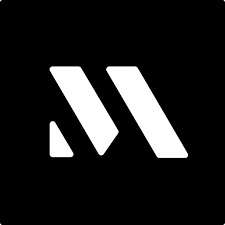
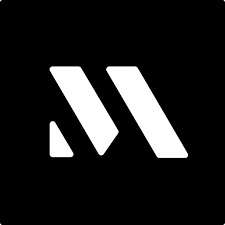

In [62]:
vybe_programs_map = get_vybe_identified_programs()

In [ ]:
vybe_programs_map

{'sageqqfewepdhh6hmdcmwy7yjhppykldnrxkb3ki8e6': 'Star Atlas SAGE',
 'mgr99qfmybytqgpwmnqunv7vblmwwxdsrhufv8jf3jm': 'Cardinal Token Manager',
 'pyts9tjg1qyazypk7n8rw8gfw9suaqqyymhjq4e7jcq': 'Pyth Staking',
 'pfacsruobdmvfmkq1bazwj27t6d2gjhschb1vcfnrmq': 'Star Atlas - PROFILE ACTION',
 'hadek9dlv9ea7ya5kctqsvsvrzejc3jgd5a9y3cnbvu': 'Hadeswap',
 'hvsrnc3nkbcryqds2docyhz9ypkevzdsjqg6rvtk1s8': 'Helium Voter Stake Registry',
 '92wdgeqyidkrcbfhobtg8hxmj932xwerckacigsw3umr': 'HXRO - Risk',
 'jcfrapv7852esrwjjgry2mysumydxzgvvhrmlmexvmvp': 'Citrus',
 'hauss13jsjafwwwgqztuqrmwyvyxn9eqpqmwv1pbbmk': 'MPL Auction House',
 'zetaxsqbrek56dhigxrn75yj2nhu3ayunxvhxpkf3ad': 'Zeta Markets',
 'craftf1egzeopfj1rpatsqg1f6hhrrbaf4gro9hdszjr': 'Star Atlas - CRAFTING',
 'mfv2hwf31z9kbca1snepyctwafyhdvnv7fznsebvaca': 'Marginfi',
 '6f3n8a6fccrb8hxnpv3t2ludfmjk6vby7miqcjpuuo6a': 'Orca-Openbook Bot',
 'swapnyd8xiqwj6ianp9snpu4bruqfxadzvhebnaxjjz': 'Stabble Stable Swap',
 'monacouxktui6vksqwalyxmxksievfnwecyxtgkbcih'

In [55]:
vybe_addresses_map = get_vybe_identified_accounts()

In [56]:
vybe_addresses_map

{'av3xwhj5esolzag6pr7lkbrgglrtaykxomdd5kbhl9yq': 'Heyitsyolo',
 '12qcuqcsmz3yx2b6268hhtrtbciwrx4hjjaagtrvn7nz': 'Openbook CATO-USDC',
 '13ucpybnakxhgvd2ddvb7o2uwxuf9gqpfkvjmvgky6uj': 'Raydium CWAR-USDC',
 '13ztudny8hvzckbk7xwrv5jt5fd9ks7bgdxp1ml1gd3h': 'Orca SOL-FISHY',
 '14ghvv3isps8cndf6pazgzb1tqs2l1yvjqanvezsiszu': 'Raydium SBONK-SOL',
 '1bwutmtvypwdtmw9abtks4ssr8no61spgavw1x6ndix': 'Magic Eden V2 Authority',
 '1fdbob8pszavbzcwnpebhjhvurfa7bge1bqk2jwmys4': 'Orca SOL-J-SOL',
 '1koyvnej5gwxz6v3re8xwxdhrephf4vnyrngv4bhrqk': 'Meteora DLMM HNT-USDC',
 '212sadyxtdwdn4v127v3k4oz2kdjvcrn7qpdsobnpahv': 'Raydium mSOL-whETH',
 '215nhcahjqqggwpqsjq7zr26etbjjtvdw74nlzwegqjp': 'verybrickedup',
 '21s8fctrhyontyaazzmjebjwyvraddzw8op74yn4wbya': 'Raydium KIN-USDC',
 '21gtfxanhudjjgzjdktxctgfkt8teixx6pn1ceg9k1uw': 'Orca SOL-USDC',
 '21nx2rm9zzjjofu3xrxlee1dq9jegj789exgv4teyjb3': 'Raydium SOL-ZBC',
 '2243xchapybqw4yazgve1bncc2ksnvr9wbctwjgqobn8': 'Orca PORT-BONK',
 '22dbujl2ztsu49ujyqus3shnftphnvkttguv

# Cross-Reference programIds and counterparties with known accounts/programs

In [74]:
vybe_programs_map = {k.lower(): v for k, v in vybe_programs_map.items()}
vybe_addresses_map = {k.lower(): v for k, v in vybe_addresses_map.items()}

# Add human-readable labels using .get() + str.lower()
tx_level_data['program_name'] = tx_level_data['program_id'].str.lower().map(lambda pid: vybe_programs_map.get(pid, 'Unknown Program'))

tx_level_data['counterparty_name'] = tx_level_data['counterparty'].astype(str).str.lower().map(lambda addr: vybe_addresses_map.get(addr, 'Unknown Address'))
tx_level_data[tx_level_data['type']=='SWAP']

,timestamp,signature,net_token_flows,counterparties,type,source,tx_status,direction,counterparty,slot,tx_fee,program_id,PRE_BALANCE,BALANCE,SYMBOL,NAME,MINT,program_name,counterparty_name
0,1738603980,5fpgxwnlgfecyzak9lkuxqtyryhgv37etzzhbtvcicqmqs...,"{'SOL': 0.023891114999999997, 'Es9vMFrzaCERmJf...","[4xDsmeTWPNjgSVSS1VTfzFq3iHZhp77ffPkAmkZkdu71,...",SWAP,JUPITER,success,received,None,318249572,0.000805,TokenkegQfeZyiNwAJbNbGKPFXCWuBvf9Ss623VQ5DA,0.003125,0.026211,SOL,Solana,So11111111111111111111111111111111111111111,Unknown Program,Unknown Address


# Nansen Data

In [64]:
# I think the API is not public yet

# Misc

In [ ]:
# # helpers/utility.py
# def _make_post_request(url: str, payload: dict, headers: dict) -> dict:
#     response = requests.post(url, json=payload, headers=headers)
#     if response.status_code == 200:
#         return response.json()
#     else:
#         raise ValueError(f"Error: {response.status_code}: {response.text}")

In [ ]:
# # Initialize with your API key (ensure it's valid and active)
# #HELIUS_API_KEY = os.getenv("api_key")  
# tx_api = TransactionsAPI(api_key=HELIUS_API_KEY)

# tx_api

In [ ]:
# # Example usage
# transactions = [""]  # Your transaction signatures
# response = tx_api.get_parsed_transactions(transactions)
# print(response)

TypeError: _make_post_request() missing 1 required positional argument: 'headers'

In [6]:
balances_api = BalancesAPI(HELIUS_API_KEY)
balances_api

In [15]:
balances_api.get_balances("hq8fC9VkxU6rv1QvMUkGKbhFR3MxSd7nCkCGaaXx9MA")

{'tokens': [{'tokenAccount': '2nKanNe6tDM5aXc2ZNvYeVKpdw4Y26dvzS19FmPiJJ4S',
   'mint': 'JD8gUc2qfvmwxtttRviHSRZ4pbGKy5nha2vdEULwx3r5',
   'amount': 3888000000,
   'decimals': 6},
  {'tokenAccount': 'GXnj7rSQtBUWcQbeP5QEyKJyv4br64uckb8xsS1sBY11',
   'mint': 'G4hdrdhnboNgFXo1uP21VwZ9zrNbxwZDmtpZt2Mnpump',
   'amount': 12126567051,
   'decimals': 6},
  {'tokenAccount': '4yLdi6X9xLRV3eezR3raibRoeAxotJA3n29uEsRfoNHL',
   'mint': 'Em9zr2tgSmGgRbz3kxyQeRXjRi9oc13wMu6cKam4zWFW',
   'amount': 74500000,
   'decimals': 6},
  {'tokenAccount': '6XWCWkwCdbBTzK5GrtTCVRQqXaB2QGuDHqZsXEt9KbBo',
   'mint': 'EWx3xDR76YfxF3VHwTLgwU9WYrwANw3yxX5vvk8Kpump',
   'amount': 119000000,
   'decimals': 6},
  {'tokenAccount': 'HSrx5V9PUuazeuen6ZYaid2o1KUbiLwDaRmJdjBmqrJZ',
   'mint': 'HD1sDvk9jjUgRv6XmVYje7ghV3udzCZhotgxSortBdga',
   'amount': 1434339522508,
   'decimals': 9},
  {'tokenAccount': '8kuTaQgk46Wo7PCuXfZuySEP85fZRgVbvCXkAfwVmt9S',
   'mint': 'Hk82ay38uGpYgqjdXXCiATavVQwAMaBNyxsUWbapmKuL',
   'amount': 